In [3]:
!pip install git+https://github.com/Dao-AILab/fast-hadamard-transform.git

  Cloning https://github.com/Dao-AILab/fast-hadamard-transform.git to /tmp/pip-req-build-ipqms28p
  Running command git clone --filter=blob:none --quiet https://github.com/Dao-AILab/fast-hadamard-transform.git /tmp/pip-req-build-ipqms28p
  Resolved https://github.com/Dao-AILab/fast-hadamard-transform.git to commit d1a56eee9d502e67faacf61b7b947180d66b32a0
  Preparing metadata (setup.py) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using ca

Matrix Size  Dense (ms)   FWHT (ms)    Dao (ms)     FWHT Speedup Dao Speedup 
32                0.032      0.455      0.089        0.07x        0.36x
64                0.031      0.541      0.089        0.06x        0.35x
128               0.036      0.621      0.089        0.06x        0.41x
256               0.036      0.758      0.106        0.05x        0.34x
512               0.032      0.792      0.095        0.04x        0.34x
1024              0.049      0.877      0.092        0.06x        0.54x
2048              0.120      0.965      0.126        0.12x        0.96x
4096              0.696      2.411      0.316        0.29x        2.21x
8192              3.836      9.230      1.230        0.42x        3.12x
16384            31.476     38.227      4.744        0.82x        6.64x
32768           260.100    161.313     20.687        1.61x       12.57x


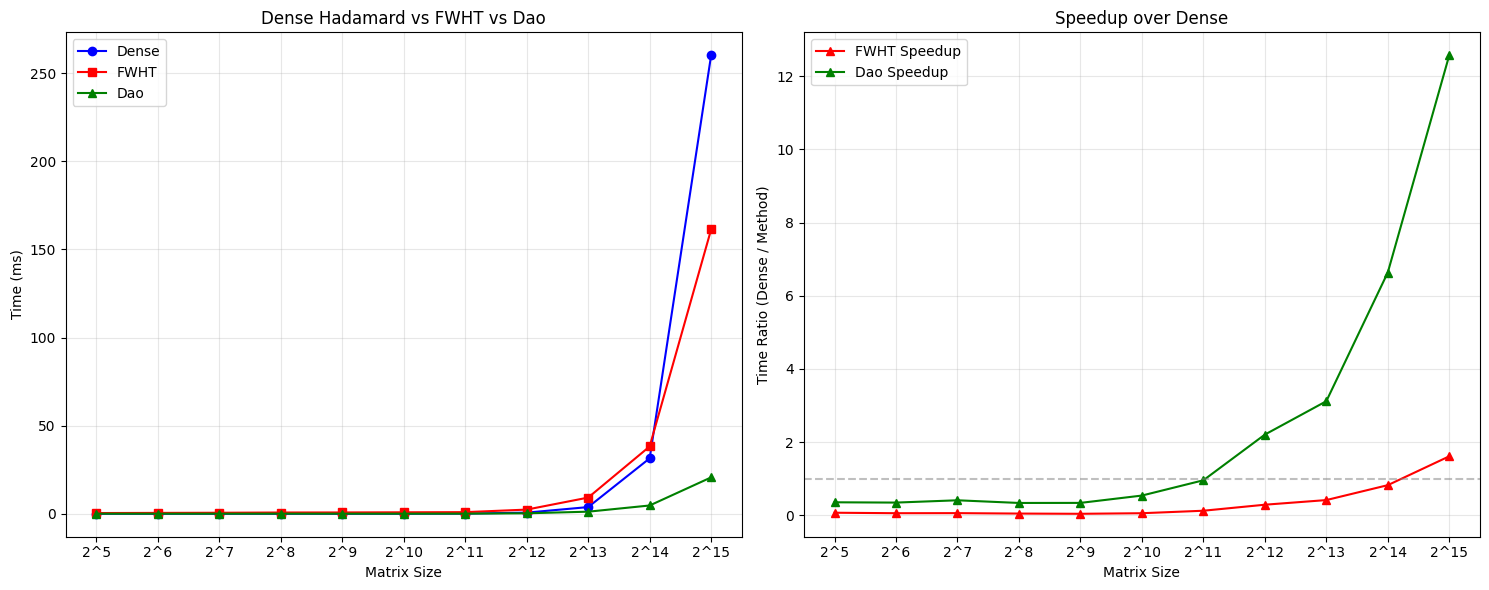

In [4]:
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
from fast_hadamard_transform import hadamard_transform

# FWHT on rows of square matrix
def fwht(X):
   N, N2 = X.shape
   assert N == N2 and (N & (N - 1)) == 0
   h = 1
   while h < N:
       X = X.view(N, N // (2 * h), 2 * h)
       a = X[:, :, :h]
       b = X[:, :, h:2 * h]
       X[:, :, :h] = a + b
       X[:, :, h:2 * h] = a - b
       X = X.view(N, N)
       h *= 2
   return X

# Dao FWHT
def dao_fwht(X):
   X_T = X.T.contiguous()
   result_T = hadamard_transform(X_T)
   return result_T.T

# Config
powers = list(range(5, 16))
matrix_sizes = [2 ** p for p in powers]
num_trials = 50
dense_times = []
fwht_times = []
dao_times = []
speedups = []
dao_speedups = []
print(f"{'Matrix Size':<12} {'Dense (ms)':<12} {'FWHT (ms)':<12} {'Dao (ms)':<12} {'FWHT Speedup':<12} {'Dao Speedup':<12}")

# Generate Hadamard matrix
def hadamard(n):
   assert n & (n - 1) == 0
   H = torch.tensor([[1.0]], device='cuda', dtype=torch.float16)
   while H.size(0) < n:
       H = torch.cat([torch.cat([H, H], dim=1),
                      torch.cat([H, -H], dim=1)], dim=0)
   return H

# Benchmark
for N in matrix_sizes:
   X = torch.randn(N, N, device="cuda", dtype=torch.float16)
   H = hadamard(N)

   # Warm up
   for _ in range(5):
       _ = torch.matmul(H, X)
       _ = fwht(X.clone())
       _ = dao_fwht(X.clone())
       torch.cuda.synchronize()

   # Dense timing
   start = time.time()
   for _ in range(num_trials):
       _ = torch.matmul(H, X)
       torch.cuda.synchronize()
   dense_time = (time.time() - start) / num_trials

   # FWHT timing
   start = time.time()
   for _ in range(num_trials):
       _ = fwht(X.clone())
       torch.cuda.synchronize()
   fwht_time = (time.time() - start) / num_trials

   # Dao timing
   start = time.time()
   for _ in range(num_trials):
       _ = dao_fwht(X.clone())
       torch.cuda.synchronize()
   dao_time = (time.time() - start) / num_trials

   dense_times.append(dense_time * 1000)
   fwht_times.append(fwht_time * 1000)
   dao_times.append(dao_time * 1000)
   speedup = dense_time / fwht_time
   dao_speedup = dense_time / dao_time
   speedups.append(speedup)
   dao_speedups.append(dao_speedup)

   print(f"{N:<12} {dense_time*1000:>10.3f} {fwht_time*1000:>10.3f} {dao_time*1000:>10.3f} {speedup:>11.2f}x {dao_speedup:>11.2f}x")

# Plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.plot(powers, dense_times, 'b-o', label='Dense')
ax1.plot(powers, fwht_times, 'r-s', label='FWHT')
ax1.plot(powers, dao_times, 'g-^', label='Dao')
ax1.set_xticks(powers)
ax1.set_xticklabels([f'2^{p}' for p in powers])
ax1.set_xlabel('Matrix Size')
ax1.set_ylabel('Time (ms)')
ax1.set_title('Dense Hadamard vs FWHT vs Dao')
ax1.grid(True, alpha=0.3)
ax1.legend()

ax2.plot(powers, speedups, 'r-^', label='FWHT Speedup')
ax2.plot(powers, dao_speedups, 'g-^', label='Dao Speedup')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_xticks(powers)
ax2.set_xticklabels([f'2^{p}' for p in powers])
ax2.set_xlabel('Matrix Size')
ax2.set_ylabel('Time Ratio (Dense / Method)')
ax2.set_title('Speedup over Dense')
ax2.grid(True, alpha=0.3)
ax2.legend()
plt.tight_layout()
plt.show()